# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [2]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [3]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [4]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


#### Load Surrogate Models

Load fine model 

In [5]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [6]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


load the data 

In [7]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [8]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [9]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [10]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [15]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")

covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
print('\nWe are using the following covariance matrix\n', covariance_matrix)


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31726257  0.31473412 30.78107406]
Optimized Params 2: [ 0.31725196  0.31476055 30.77755351]
Optimized Params 3: [ 0.31713708  0.3149398  30.75060943]
Optimized Params 4: [ 0.31719524  0.31483872 30.76532289]
Optimized Params 5: [ 0.31728283  0.31470401 30.78567799]

We are using the following covariance matrix
 [[8.38209589e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.24993791e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.47439207e+00]]


MDA

In [16]:
N_iter = 4100
N_subsampl = 250
scale = 0.075


In [26]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
ESS_values = []
start_0 = timeit.default_timer() 
samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=N_iter, n_chains=1,
                           initial_parameters=initial_guesses[0], 
                           subsampling_rate = N_subsampl)

end_0 = timeit.default_timer() 

idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(100, None,5), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")
    # Compute the Effective Sample Size (ESS) 
ess = az.ess(idata)
ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])

print('Time MDA', (end_0-start_0))
print('Time/ESS MDA',(end_0-start_0)/(np.mean(ESS_values, axis=0)) )



Sampling chain 1/1


Running chain, α_c = 0.070, α_f = 0.23: 100%|██████████| 4100/4100 [01:00<00:00, 67.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 238.0
    Offset     float64 8B 241.0
    Thickness  float64 8B 219.7 

Time MDA 60.54351183300605
Time/ESS MDA [0.25441976 0.25123445 0.27556365]


Only fine 

In [27]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.1)
ESS_values = []
start_0 = timeit.default_timer() 
samples = tda.sample(my_posterior_fine, my_proposal, 
                         iterations=150000, n_chains=1,
                           initial_parameters=initial_guesses[0])

end_0 = timeit.default_timer() 

idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(1000, None,100), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")
    # Compute the Effective Sample Size (ESS) 
ess = az.ess(idata)
ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])

print('Time MDA', (end_0-start_0))
print('Time/ESS MDA',(end_0-start_0)/np.mean(ESS_values, axis = 0) )

Sampling chain 1/1


Running chain, α = 0.01: 100%|██████████| 150000/150000 [07:24<00:00, 337.72it/s]


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 153.8
    Offset     float64 8B 177.5
    Thickness  float64 8B 139.8 

Time MDA 444.2318951670022
Time/ESS MDA [2.88841072 2.50325889 3.1779024 ]


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


# Diagnostics 

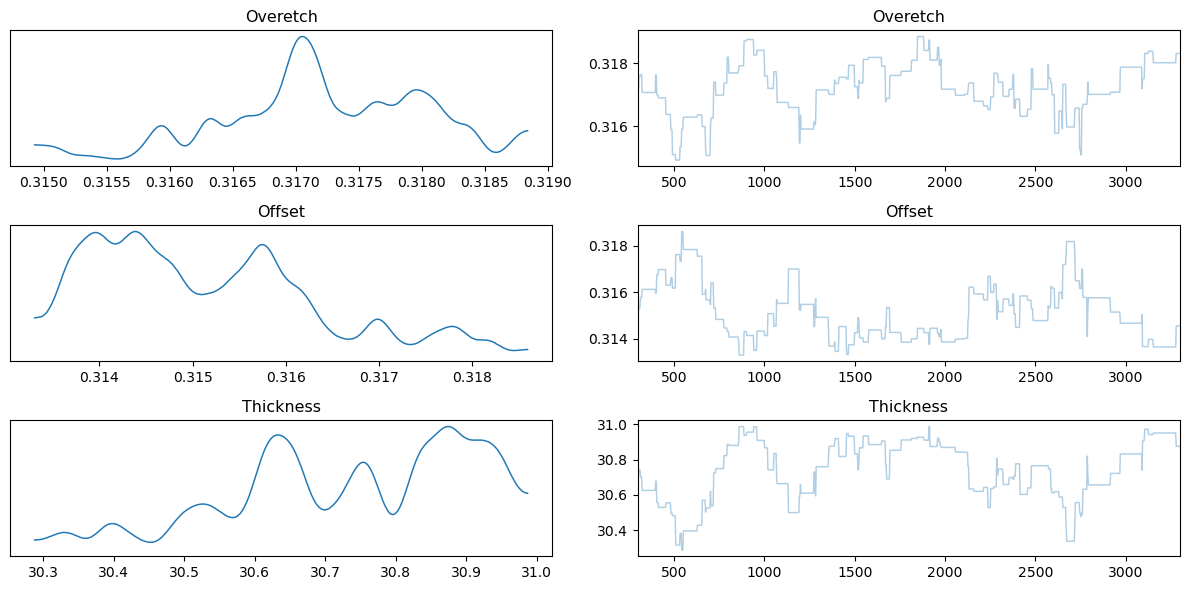

In [14]:
# Plot trace of the first set of samples
#idata = 
az.plot_trace(idata)
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

In [39]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

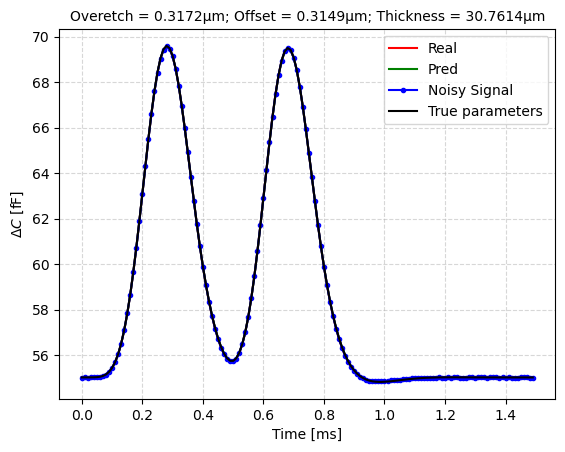

In [41]:
# Plotting and data collection
#data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, model_lf, data)

Finally, let's look at the parameters distribution

In [42]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

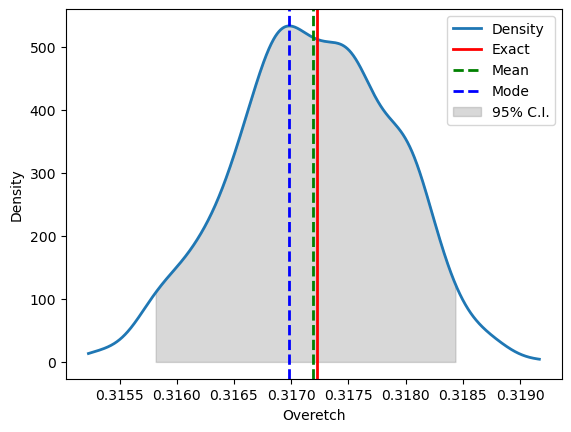

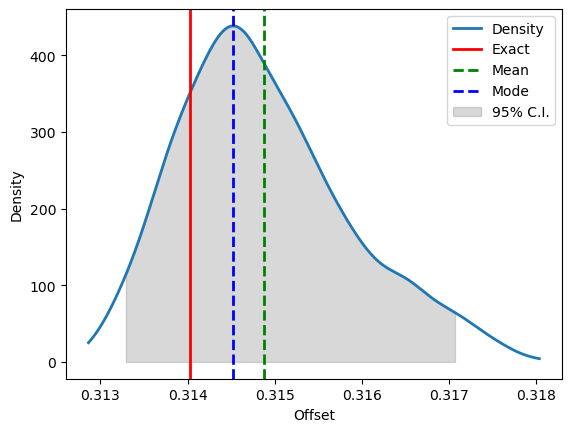

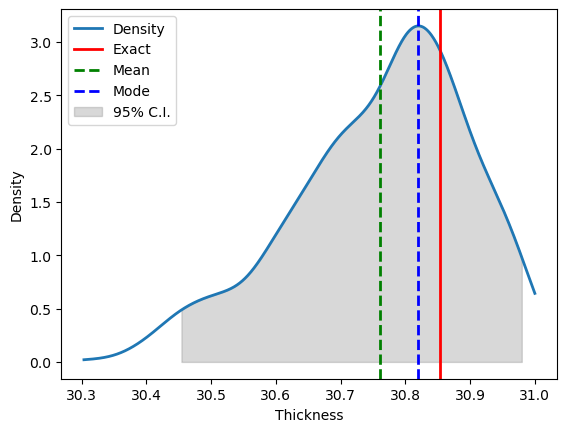

In [43]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Gridsearch for optimal parameters

In [54]:
subsampling_rate_values = [1 , 5 , 10 , 25 , 50 , 100, 250, 500,750]
scaling_values = [0.01, 0.03, 0.05 , 0.075, 0.09, 0.1, 0.25, 0.5, 0.75, 1 ]

In [55]:
Saved = True

M = np.zeros((len(subsampling_rate_values), len(scaling_values)))
if (not Saved):
    for index1, ssr in enumerate(subsampling_rate_values):
        for index2, scale in enumerate(scaling_values): 
            # Adaptive Metropolis
            my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
            # Initialize a list to hold the Effective sample sizes for each initial guess
            ESS_values = []
            # Iterate over each initial guess to set up and run the Markov chain sampler
            for index, initial_guess in enumerate(initial_guesses[0:1]):
                samples = tda.sample(my_posteriors, my_proposal, 
                            iterations=4000, n_chains=1,
                            initial_parameters=initial_guess, 
                            subsampling_rate = ssr)
                            #adaptive_error_model='state-independent')
                idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
                # Remove the burnin and sub-sample
                idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
                ess = az.ess(idata)
                ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
                if(index==0):
                    print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))
            # Add the mean of the different sample sizes to the matrix
            M[index1, index2] = np.mean(ESS_values)
else: 
    M = np.load('matrix_ssr_scale.npy')


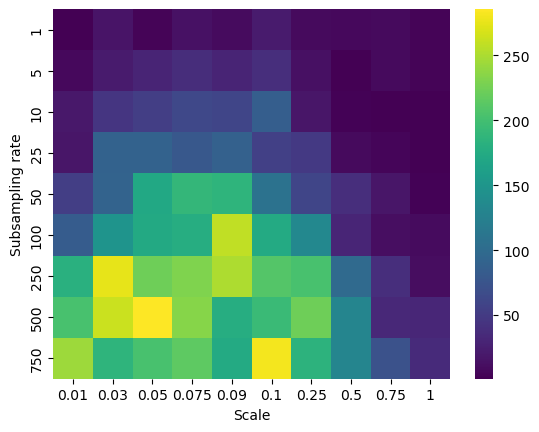

In [56]:
# Plot heatmap

sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()

# See perfomance for 10 samples 

In [68]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.075) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=3300, n_chains=1, initial_parameters=init_guess,subsampling_rate = 3)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(300, None, 3), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    

The extracted samples are:  [125, 60, 53, 89, 9, 61, 156, 99, 92, 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α_c = 0.460, α_f = 0.22: 100%|██████████| 3300/3300 [00:09<00:00, 332.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.42: 100%|██████████| 3300/3300 [00:10<00:00, 314.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α_c = 0.613, α_f = 0.30: 100%|██████████| 3300/3300 [00:11<00:00, 291.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.30: 100%|██████████| 3300/3300 [00:09<00:00, 331.24it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.44: 100%|██████████| 3300/3300 [00:10<00:00, 327.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α_c = 0.683, α_f = 0.37: 100%|██████████| 3300/3300 [00:10<00:00, 318.31it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α_c = 0.697, α_f = 0.33: 100%|██████████| 3300/3300 [00:10<00:00, 308.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.30: 100%|██████████| 3300/3300 [00:10<00:00, 311.78it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α_c = 0.600, α_f = 0.43: 100%|██████████| 3300/3300 [00:10<00:00, 318.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.34: 100%|██████████| 3300/3300 [00:10<00:00, 313.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


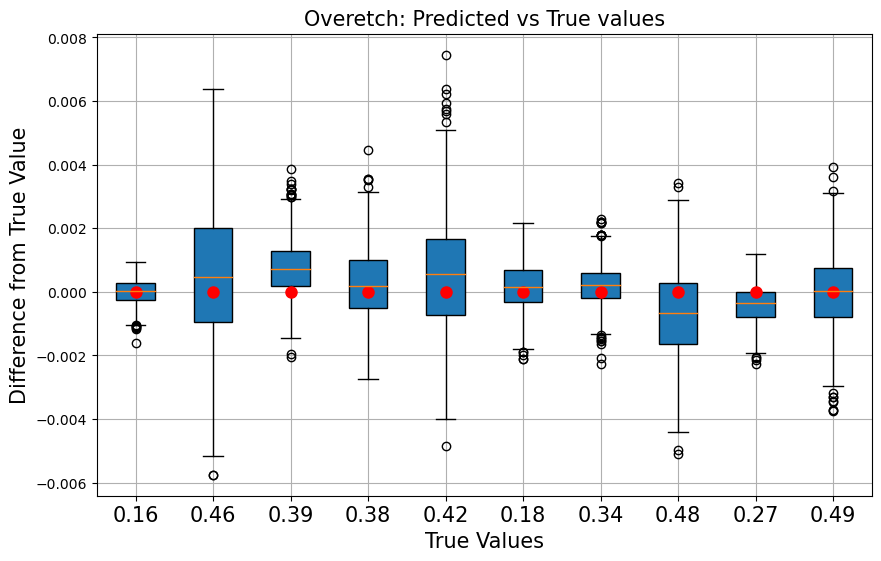

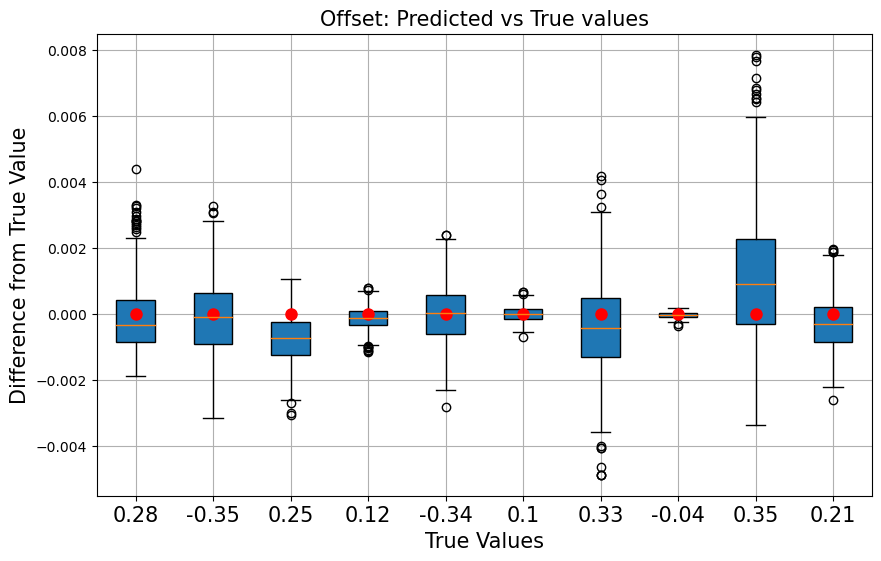

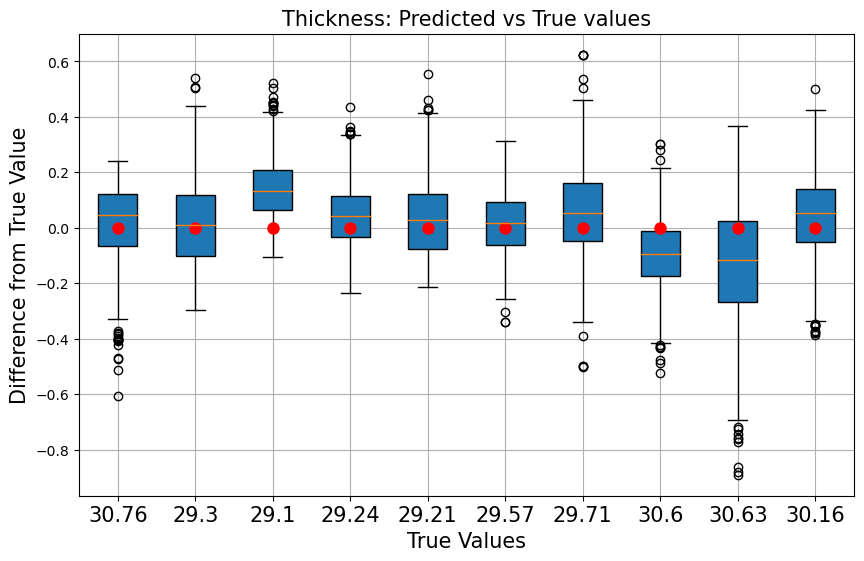

In [69]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()